# Programming for Data Analytics Project
# Analysis of Wind Speed Data

*Author: Eoghan Walsh*
***

## Short Desciption

## Import Modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
import csv
import re
import requests
from io import StringIO
import geopandas as gpd
from shapely.geometry import Point

## Import and Clean the Monthly Windspeed Data

In [69]:
# Function to import and clean the monthly weather date.
def import_monthly_data():

    # File containing csv URLs.
    txt_file = "./data/download-file-list-monthly.txt"

    # Regex pattern to find the start of useful data in CSV files.
    regex = r"^year(?!:)"

    # Columns to import to dataframe.
    columns = ["year","month", "wdsp"]

    # Numeric columns.
    numeric_columns = ["wdsp"]

    # List to store the dataframes.
    dataframes = []

    # Regex pattern to find the column header row in CSV files.
    regex_pattern = re.compile(regex, re.IGNORECASE)

    # Read the URLs from the txt file and strip newlines.
    with open(txt_file) as f:
        csv_urls = [line.strip() for line in f if line.strip()]

    # Loop through the URLs.
    for url in csv_urls:
        try:
            # Send GET request to the URL.
            response = requests.get(url)
            if response.status_code != 200:
                print(f"Failed to retrieve the CSV file. Status code: {response.status_code}")
                continue

            # Treat response content as file-like object.
            csv_content = response.text
            csv_file = StringIO(csv_content)

            # Find the row with column headers.
            csv_reader = csv.reader(csv_file)

            station_name = ",".join(next(csv_reader)).split("Station Name: ")[1].lower().replace(" ", "_")

            for row_number, row in enumerate(csv_reader):
                row_string = ",".join(row)
                if regex_pattern.search(row_string):
                    break
            else:
                print(f"Error finding regex pattern: \"{regex_pattern.pattern}\" in {url}")
                continue

            # Reset the file pointer and import the data to DataFrame.
            csv_file.seek(0)
            df = pd.read_csv(csv_file, skiprows=row_number, usecols=columns)

            # Add new date column.
            df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str))
            
            # Set date column as index.
            df = df.set_index('date')

            # Drop year and month columns.
            df = df.drop(columns=['year', 'month'])

            # Convert data to numeric.
            for col in numeric_columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

            # Update column names to include station name.
            df.columns = [f"{station_name}"]

            # Append dataframes to list.
            dataframes.append(df)

            print(f"Imported {url} as {station_name}")

        except Exception as e:
            print(f"An error occurred while processing {url} ({station_name}): {e}")

    return dataframes


# Call the function.
dataframes = import_monthly_data()

Imported https://cli.fusio.net/cli/climate_data/webdata/mly1875.csv as athenry
Imported https://cli.fusio.net/cli/climate_data/webdata/mly675.csv as ballyhaise
Imported https://cli.fusio.net/cli/climate_data/webdata/mly2375.csv as belmullet
Imported https://cli.fusio.net/cli/climate_data/webdata/mly3723.csv as casement
Imported https://cli.fusio.net/cli/climate_data/webdata/mly2175.csv as claremorris
Imported https://cli.fusio.net/cli/climate_data/webdata/mly3904.csv as cork_airport
Imported https://cli.fusio.net/cli/climate_data/webdata/mly532.csv as dublin_airport
Imported https://cli.fusio.net/cli/climate_data/webdata/mly1375.csv as dunsany
Imported https://cli.fusio.net/cli/climate_data/webdata/mly2075.csv as finner
Imported https://cli.fusio.net/cli/climate_data/webdata/mly1475.csv as gurteen
Imported https://cli.fusio.net/cli/climate_data/webdata/mly1775.csv as johnstown_castle_2
Imported https://cli.fusio.net/cli/climate_data/webdata/mly4935.csv as knock_airport
Imported https:/

In [ ]:
# Combine into one dataframe and normalize based on the date index.
# https://pandas.pydata.org/docs/reference/api/pandas.concat.html#pandas-concat
monthly_df = pd.concat(dataframes, axis=1, join='inner')

monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 158 entries, 2011-02-01 to 2024-11-01
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   athenry               158 non-null    float64
 1   ballyhaise            157 non-null    float64
 2   belmullet             158 non-null    float64
 3   casement              158 non-null    float64
 4   claremorris           153 non-null    float64
 5   cork_airport          158 non-null    float64
 6   dublin_airport        158 non-null    float64
 7   dunsany               158 non-null    float64
 8   finner                158 non-null    float64
 9   gurteen               157 non-null    float64
 10  johnstown_castle_2    157 non-null    float64
 11  knock_airport         158 non-null    float64
 12  mace_head             157 non-null    float64
 13  malin_head            157 non-null    float64
 14  markree               0 non-null      float64
 15  moor

In [59]:
# Drop markee and pheonix park as no wind speed data.
monthly_df = monthly_df.drop(columns=['markree', 'phoenix_park'])

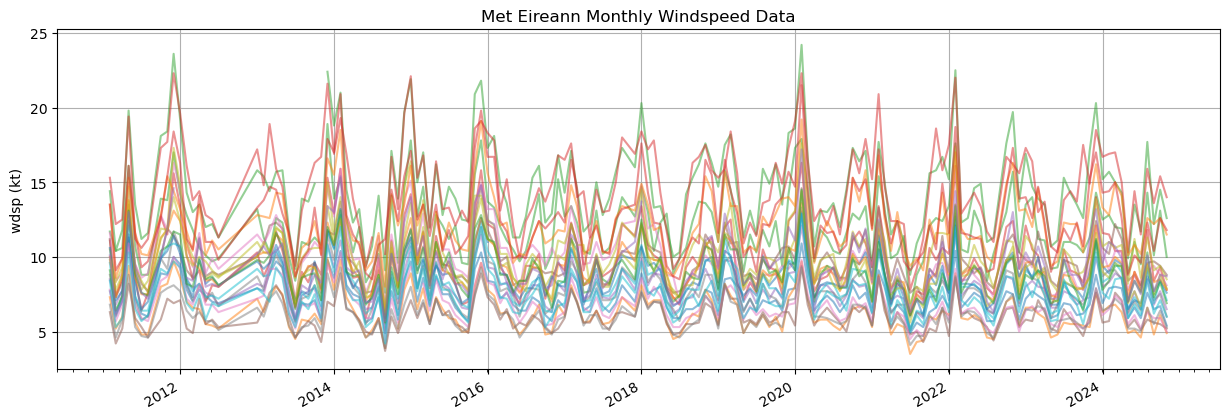

In [106]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(monthly_df, alpha=0.5)


locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
fig.autofmt_xdate()

ax.set_ylabel("wdsp (kt)")

ax.grid(True)

ax.set_title("Met Eireann Monthly Windspeed Data")

plt.show()

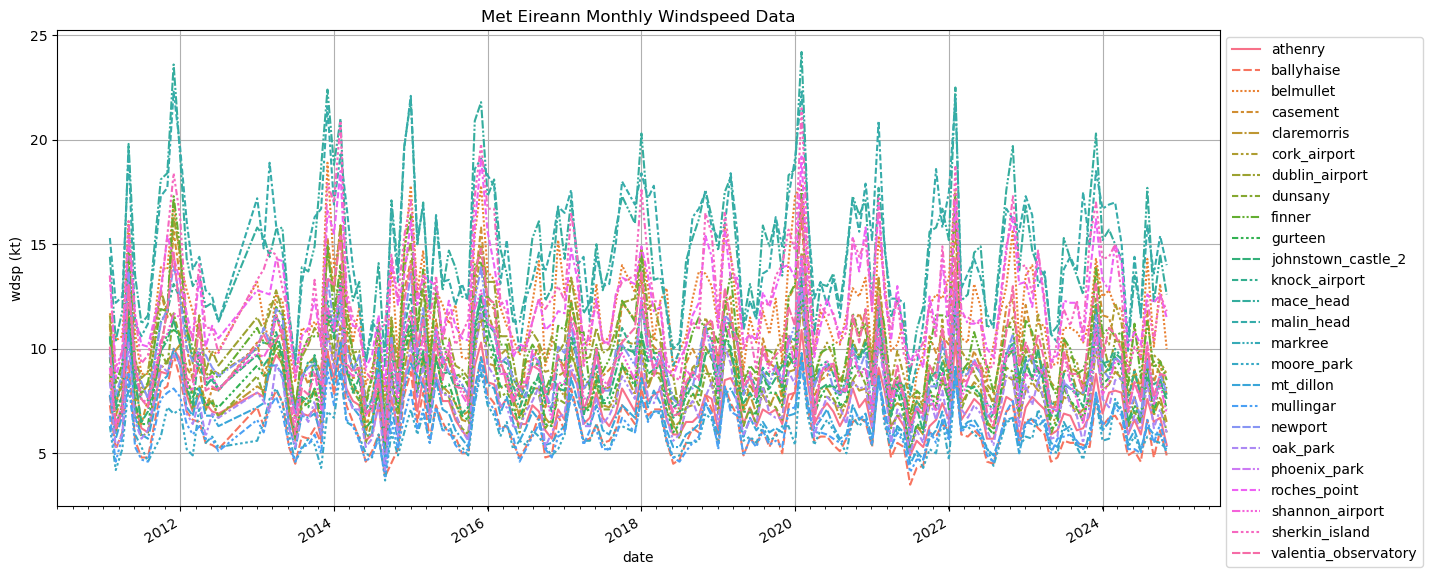

In [105]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.lineplot(data=monthly_df, ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
fig.autofmt_xdate()

ax.set_ylabel("wdsp (kt)")

ax.grid(True)

ax.set_title("Met Eireann Monthly Windspeed Data")

plt.show()

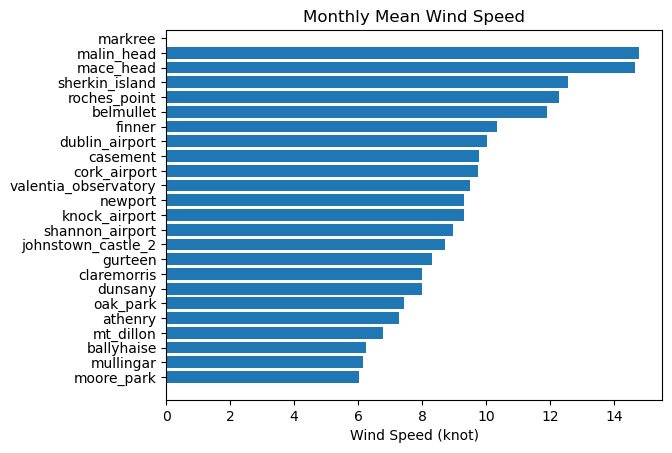

In [81]:
windspeed = monthly_df.mean().sort_values(ascending=True)

fig, ax = plt.subplots()

ax.barh(windspeed.index, windspeed)

ax.set_title("Monthly Mean Wind Speed")
ax.set_xlabel("Wind Speed (knot)")
#ax.set_ylabel("Met Eireann Synoptic Weather Stations")
plt.show()